In [7]:
import matplotlib.pyplot as plt
from image_util import I

## Filters
---


forward difference: $ f'(x) = \frac{f(x+h) - f(x)}{h}$

backward difference: $ f'(x) = \frac{f(x) - f(x-h)}{h}$

central difference: $f'(x)=\frac{f(x+h) - f(x-h)}{2h}$

### Padding

In [172]:
import copy

def pad_image(image, padding_height, padding_width):
    image = copy.deepcopy(image) # Avoid modifying the original image
    padded_image = []
    rows = len(image)
    cols = len(image[0])
    channels = len(image[0][0]) if type(image[0][0]) == list else 1 

    # Adjust channels
    zeros = [0] * channels
    if (channels == 1):
        zeros = 0

    # Pad rows at the top and bottom
    for i in range(padding_height):
        padded_image.append([zeros] * cols)
    for row in image:
        padded_image.append(row)
    for i in range(padding_height):
        padded_image.append([zeros] * cols)

    # Pad columns at the left and right
    for i in range(len(padded_image)):
        for j in range(padding_width):
            padded_image[i].insert(0, zeros)
        for j in range(padding_width):
            padded_image[i].append(zeros)

    return copy.deepcopy(padded_image)

### Convolution

In [180]:
import copy

def convolution(image, kernel):
    '''
    Performs convolution between an image and a kernel
    '''
    image = copy.deepcopy(image) # Avoid modifying the original image
    
    padding_height = len(kernel) // 2
    padding_width = len(kernel[0]) // 2
    
    # Pad the image
    padded_image = pad_image(image, padding_height, padding_width)
    
    
    # Create an output matrix with the same dimensions as the input image
    output = [[0] * len(image[0]) for i in range(len(image))]

    # Perform convolution
    image_height = len(image)
    image_width = len(image[0])
    kernel_height = len(kernel)
    kernel_width = len(kernel[0])
    
    for i in range(image_height):
        for j in range(image_width):
            for k in range(kernel_height):
                for l in range(kernel_width):
                    output[i][j] = output[i][j] +  padded_image[i + k][j + l] * kernel[k][l]

    return output

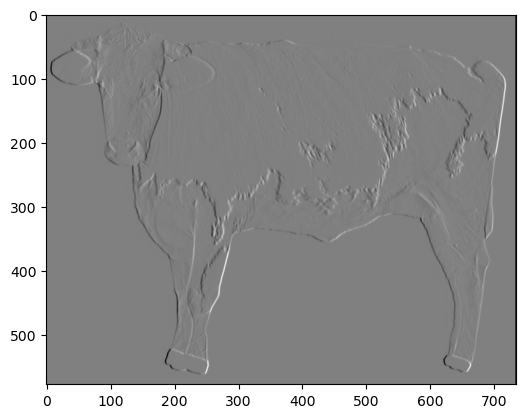

In [188]:
img = I.from_np(plt.imread('data/no_bg/img/sapi1.jpg')).image
gray = I.to_gray(img)
conv = convolution(gray, kernel=[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
I.show(conv, gray=True)

### Edge detection

In [261]:
def edge_detection(
    img: list,
    x_kernel: list = [[-1, 0, 1], 
                     [-2, 0, 2], 
                     [-1, 0, 1]],
    y_kernel: list = [[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]]
    ) -> list:
    '''
    detect edges in an image
    '''
    # convert image to grayscale
    if type(img[0][0]) != int and len(img[0][0]) == 3:
        img = I.to_gray(img)
    
    # create edge image
    edge = []
       
    # calculate the gradient in the x-direction and y-direction
    Ix = convolution(img, x_kernel)
    Iy = convolution(img, y_kernel)
        
    # loop through the image
    for i in range(len(img)):
        edge.append([])
        for j in range(len(img[0])):
            # calculate the gradient magnitude
            edge[i].append([int((Ix[i][j]**2 + Iy[i][j]**2)**0.5)])
            
    return edge

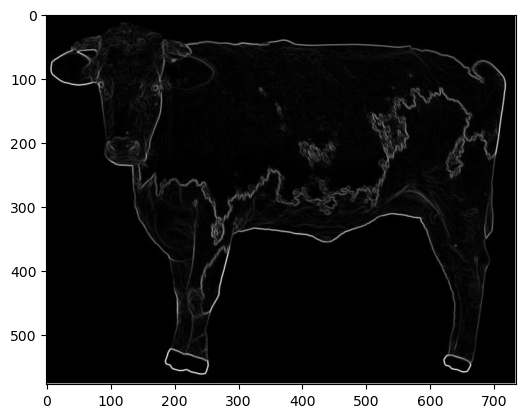

In [200]:
img = I.from_np(plt.imread('data/no_bg/img/sapi1.jpg')).image
edge = edge_detection(img)
I.show(edge, gray=True)

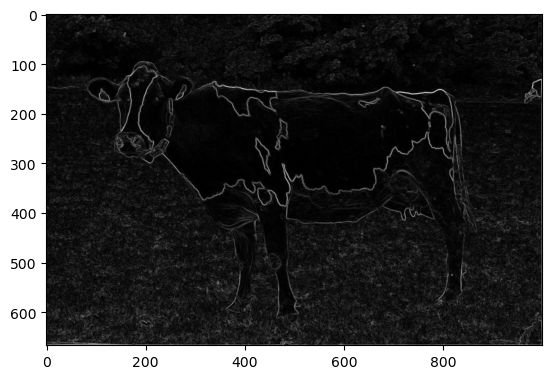

In [264]:
bg = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
edge = edge_detection(bg)
I.show(edge, gray=True)

### Median Filter

In [251]:
def median_filter(gray_img, mask=3):
    """
    :param gray_img: gray image
    :param mask: mask size
    :return: image with median filter
    """
    # set image borders
    bd = int(mask / 2)
    
    row = len(gray_img)
    col = len(gray_img[0])
    
    # copy image size
    median_img = [[0] * col for i in range(row)]
    
    for i in range(bd, row - bd):
        for j in range(bd, col - bd):
            # get mask according with mask
            kernel = [[gray_img[i - bd + k][j - bd + l] for l in range(mask)] for k in range(mask)]
            kernel = I.flatten(kernel)
            sorted_list = sorted(kernel)
            # calculate mask median
            median = sorted_list[int(len(sorted_list) / 2)]
            median_img[i][j] = median
    return median_img

In [238]:
my_list = [[1, 2, 3],
           [4, 5, 6],
           [7, 8, 9]]

# Extract a rectangular portion
rows = [0, 2]
columns = [1]
sliced_list = [[my_list[row][col] for col in range(2)] for row in range(0, 2)]
sliced_list

[[1, 2], [4, 5]]

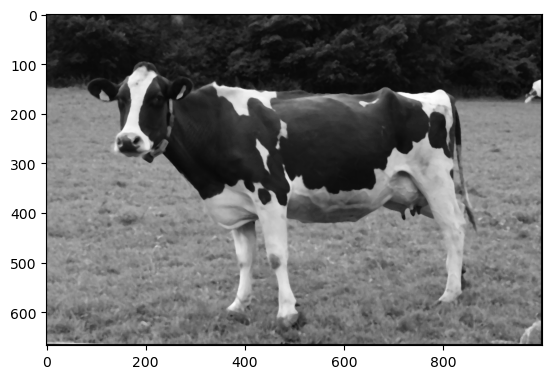

In [254]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
gray = I.to_gray(img)
median = median_filter(gray, mask=5)
I.show(median, gray=True)

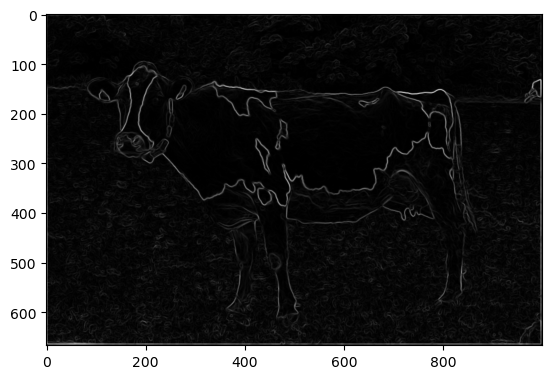

In [262]:
edge = edge_detection(median)
I.show(edge, gray=True)

## Implement
---